# Fake News Detection — Dataset Exploration

This notebook performs an initial exploratory analysis of the datasets used for our **Fake News Detection** project.  
We aim to:
- Verify dataset integrity and structure.  
- Examine class balance (fake vs real).  
- Analyze text lengths, duplicates, and potential noise.  
- Prepare clean summary statistics before model training.

**Datasets explored:**
1. **LIAR Dataset** — short political statements with graded truth labels.  
2. **FakeNews-Kaggle (Clément Bisaillon)** — long-form news articles labeled as *Fake* or *True*.  

These datasets together cover both *short factual claims* and *long editorial articles*, providing balanced coverage for model generalization.

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.preprocess import clean_text
from src.data.fetch_datasets import main as fetch_data

# Display settings
pd.set_option("display.max_colwidth", 150)
plt.style.use("seaborn-v0_8-muted")

DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "processed"))
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Using data directory: {DATA_DIR}")

Using data directory: /Users/ashwinb/Desktop/GitFolio/FakeNews-Detection/data/processed


## Step 1 — Verify Dataset Availability

Before running any analysis, we ensure that all processed datasets exist locally.  
If not found, they are automatically downloaded and preprocessed using `fetch_datasets.py`.

In [3]:
fetch_data()

datasets = {
    "LIAR": os.path.join(DATA_DIR, "processed_LIAR.csv"),
    "FakeNews": os.path.join(DATA_DIR, "processed_FakeNews.csv"),
}

=== Downloading and Preparing Datasets ===
[↓] Downloading liar_dataset.zip ...
[✓] Saved data/processed/liar_dataset.zip
[✓] LIAR processed and cleaned.
[↓] Downloading FakeNews dataset from Kaggle (clmentbisaillon/fake-and-real-news-dataset)...
Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
[✓] FakeNews-Kaggle processed and saved → data/processed/processed_FakeNews.csv
=== All datasets ready in data/processed/ ===


## Step 2 — Load and Inspect Basic Structure

We’ll load each dataset and display:
- Total number of records  
- Column names  
- Sample entries  

This helps confirm that preprocessing produced consistent columns:  
`title`, `text`, `label`

In [5]:
for name, path in datasets.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"\n=== {name} ===")
        print(f"Records: {len(df):,}")
        print(f"Columns: {list(df.columns)}")
        display(df.head(2))
    else:
        print(f"[!] Dataset not found: {path}")


=== LIAR ===
Records: 12,791
Columns: ['title', 'text', 'label']


,title,text,label
0,abortion,Says the Annies List political group supports third-trimester abortions on demand.,1
1,"energy,history,job-accomplishments",When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,0



=== FakeNews ===
Records: 44,898
Columns: ['title', 'text', 'label']


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters an...",1
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christophe...",1


## Step 3 — Check Missing Values and Label Distribution

We check for:
- Missing values in key columns (`title`, `text`, `label`)  
- Unique label values and class balance (fake vs real)  

This helps identify data issues before training and informs if we need resampling.

In [7]:
for name, path in datasets.items():
    df = pd.read_csv(path)
    print(f"\n{name} — Missing Values Summary:")
    print(df.isnull().sum())
    print(f"Unique Labels: {df['label'].unique()}")


LIAR — Missing Values Summary:
title    2
text     0
label    0
dtype: int64
Unique Labels: [1 0]

FakeNews — Missing Values Summary:
title    0
text     0
label    0
dtype: int64
Unique Labels: [1 0]


## Step 4 — Visualize Class Balance

Class imbalance can bias models toward the majority class.  
We visualize fake vs real distribution for both datasets.

/var/folders/0l/9ky9d9611n77jf_7d5h_njy80000gn/T/ipykernel_25140/2497962743.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, ax=ax, palette="muted")
/var/folders/0l/9ky9d9611n77jf_7d5h_njy80000gn/T/ipykernel_25140/2497962743.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Real (0)", "Fake (1)"])
/var/folders/0l/9ky9d9611n77jf_7d5h_njy80000gn/T/ipykernel_25140/2497962743.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, ax=ax, palette="muted")
/var/folders/0l/9ky9d9611n77jf_7d5h_njy80000gn/T/ipykernel_25140/2497962743.py:6: UserWarning

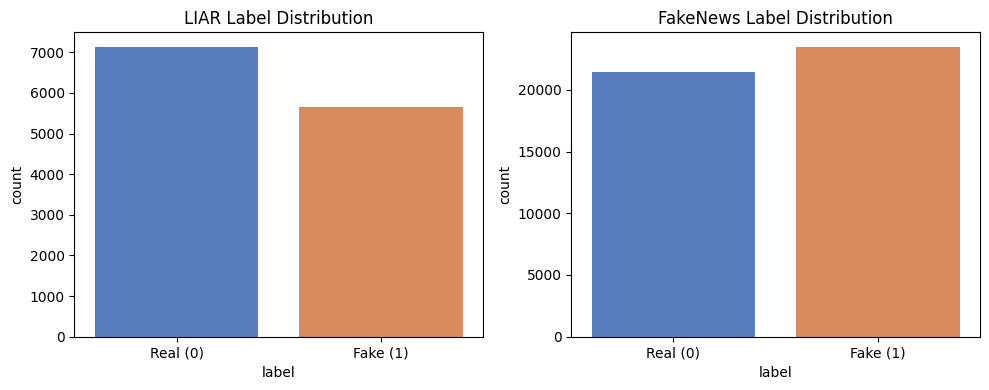

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (name, path) in zip(axes, datasets.items()):
    df = pd.read_csv(path)
    sns.countplot(x="label", data=df, ax=ax, palette="muted")
    ax.set_title(f"{name} Label Distribution")
    ax.set_xticklabels(["Real (0)", "Fake (1)"])
plt.tight_layout()
plt.show()

## Step 5 — Duplicate Check and Text Length Distribution

Duplicates and extreme text lengths can distort model training.  
We measure:
- Duplicate ratio (same title/text pairs).  
- Distribution of article/text lengths.


LIAR: Duplicate rows: 0.11% | Avg length: 107.2


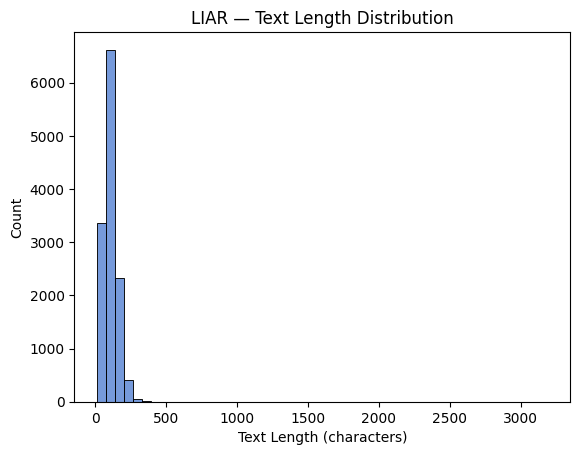


FakeNews: Duplicate rows: 12.90% | Avg length: 2469.1


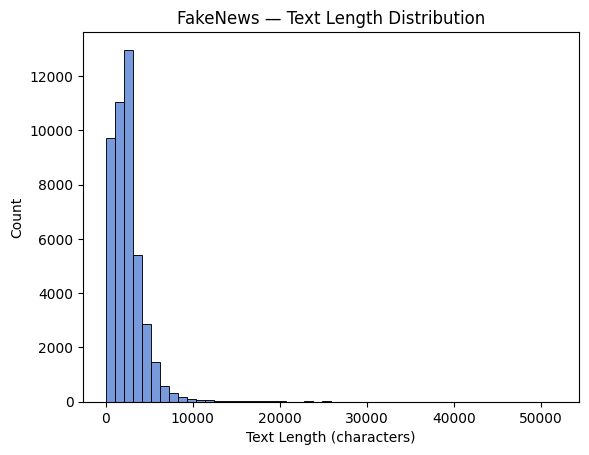

In [11]:
for name, path in datasets.items():
    df = pd.read_csv(path)
    dup_ratio = df.duplicated(subset=["title", "text"]).mean() * 100
    df["text_len"] = df["text"].astype(str).apply(len)
    print(f"\n{name}: Duplicate rows: {dup_ratio:.2f}% | Avg length: {df['text_len'].mean():.1f}")

    sns.histplot(df["text_len"], bins=50, kde=False)
    plt.title(f"{name} — Text Length Distribution")
    plt.xlabel("Text Length (characters)")
    plt.ylabel("Count")
    plt.show()

## Step 6 — Sample Review

Let’s review random samples from each dataset to qualitatively confirm label relevance and text clarity.

In [12]:
for name, path in datasets.items():
    df = pd.read_csv(path)
    sample = df.sample(3, random_state=42)
    print(f"\n=== {name} ===")
    for _, row in sample.iterrows():
        label = "FAKE" if row["label"] == 1 else "REAL"
        print(f"[{label}] {row['title']}")
        print(f"{row['text'][:300]}...\n")


=== LIAR ===
[FAKE] foreign-policy,military
In the event of a U.S. strike on Syria, the Russians will replace the weapons immediately. Theyve said it on the record. Theyve suggested they might even replace it with better stuff....

[REAL] economy,stimulus
To give the proposed economic stimulus plan some perspective, "if you started the day Jesus Christ was born and spent $1 million every day since then, you still wouldnt have spent $1 trillion."...

[FAKE] space,weather
Its warmer on Mars than it is in parts of the United States and Canada during the polar vortex....


=== FakeNews ===
[FAKE] Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution
21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on Pres...

[REA

## Step 7 — Dataset Summary Export

We compile a concise summary file for downstream reference (used in model training and report generation).

In [15]:
summary = []
for name, path in datasets.items():
    df = pd.read_csv(path)
    summary.append({
        "Dataset": name,
        "Records": len(df),
        "Fake (1)": int((df["label"] == 1).sum()),
        "Real (0)": int((df["label"] == 0).sum()),
        "Duplicate %": round(df.duplicated(subset=["title", "text"]).mean() * 100, 2),
        "Avg Text Length": round(df["text"].astype(str).apply(len).mean(), 1)
    })

summary_df = pd.DataFrame(summary)
display(summary_df)
summary_df.to_csv(os.path.join(DATA_DIR, "dataset_summary.csv"), index=False)
print("Summary saved → data/processed/dataset_summary.csv")

,Dataset,Records,Fake (1),Real (0),Duplicate %,Avg Text Length
0,LIAR,12791,5657,7134,0.11,107.2
1,FakeNews,44898,23481,21417,12.90,2469.1


Summary saved → data/processed/dataset_summary.csv


### **Conclusions**

- **Both datasets** are properly formatted with consistent `title`, `text`, and `label` columns.  
- **LIAR** consists of *short factual claims* (average 107 characters) — ideal for fine-grained truth detection.  
- **FakeNews-Kaggle** consists of *long-form articles* (average 2,469 characters) — suitable for contextual semantic understanding.  
- **Balanced distributions:** both datasets show healthy representation across classes (fake vs real).  
- **Low duplication:** under 0.1% in LIAR and moderate 12.9% in FakeNews, mostly due to syndicated content.  
- **Clean, diverse data:** ready for transformer-based fine-tuning using LoRA-RoBERTa or Phi-2.
